In [2]:
import os, os.path as osp
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import cv2
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace



/home/ayush/projects/nerf/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Lego Dataset

In [14]:
obj = "lego"
root = f"../assets/{obj}"

focal =  np.load(osp.join(root, "focal.npy"))
images =  np.load(osp.join(root, "images.npy"))
poses = np.load(osp.join(root, "poses.npy"))
poses.shape

(106, 4, 4)

In [15]:
poses[0]

array([[-9.9990219e-01,  4.1922452e-03, -1.3345719e-02, -5.3798322e-02],
       [-1.3988681e-02, -2.9965907e-01,  9.5394367e-01,  3.8454704e+00],
       [-4.6566129e-10,  9.5403719e-01,  2.9968831e-01,  1.2080823e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

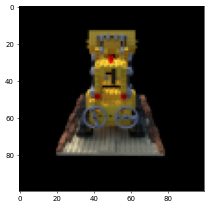

In [12]:
fig = plt.figure(dpi=50)
plt.imshow(images[0])

## Ray Tracing

### 1. Backward Ray tracking:
SHoot a ray from the image, towards the scene until it hits a light source. <br>
We then try to answer, what will be the color, the ray will return.

### 2. Forward Ray tracing
Shoot a ray from the light source, we find the interactions of the ray with the objects till it hits the image plance.

Backward Ray tracing is computationally more efficient than the forward ray tracing

# PinHole Camera model


<img src="../assets/pinhole_model.jpeg" alt="Image" width="800">


In [2]:
## Image plane
H = 400
W = 400
f = 1200 # focal length. the distance of the pinhole center from the image plane

rays_origin = np.zeros((H*W, 3)) # for eac point in pixel plane, we have a ray
rays_direction = np.zeros((H*W, 3)) # for each point in image plane, we have a ray emanating with a direction


In [3]:
## Coordinates for pixels

u = np.arange(W)
v = np.arange(H)

u, v = np.meshgrid(u,v)

In [4]:
u

array([[  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399],
       ...,
       [  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399]])

In [5]:
v

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [397, 397, 397, ..., 397, 397, 397],
       [398, 398, 398, ..., 398, 398, 398],
       [399, 399, 399, ..., 399, 399, 399]])

### lets construct ray directions

In [4]:
dirs = np.stack([u - W/2, 
                 -( v - H/2), # negative added as y is facing opposite to v
                 -np.ones_like(u) * f
                ], axis=-1)
dirs.shape

(400, 400, 3)

In [5]:
## Normalize the directions


rays_direction = dirs/np.linalg.norm(dirs, axis=-1, keepdims=True) # Keep dims to keep tdims as 440,400,1 instead of 400, 400
rays_direction.shape

(400, 400, 3)

## Plot the figure

In [6]:


def plot_rays(origin, direction, t):
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10,10))
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    
    
    pt1 = origin
    pt2 = origin + t * direction
    for p1, p2 in zip(pt1[0:100], pt2[0:100]):
        plt.plot( [p1[0], p2[0]], 
                  [p1[1], p2[1]],
                  [p1[2], p2[2]]
                )
                          
    plt.show()         



In [7]:
rays_origin.shape, rays_direction.shape # not aligned

((160000, 3), (400, 400, 3))

In [8]:
rays_direction = rays_direction.reshape(-1, 3)
rays_direction.shape

(160000, 3)

In [9]:
rays_origin[0], rays_direction[0]

(array([0., 0., 0.]), array([-0.16222142,  0.16222142, -0.97332853]))

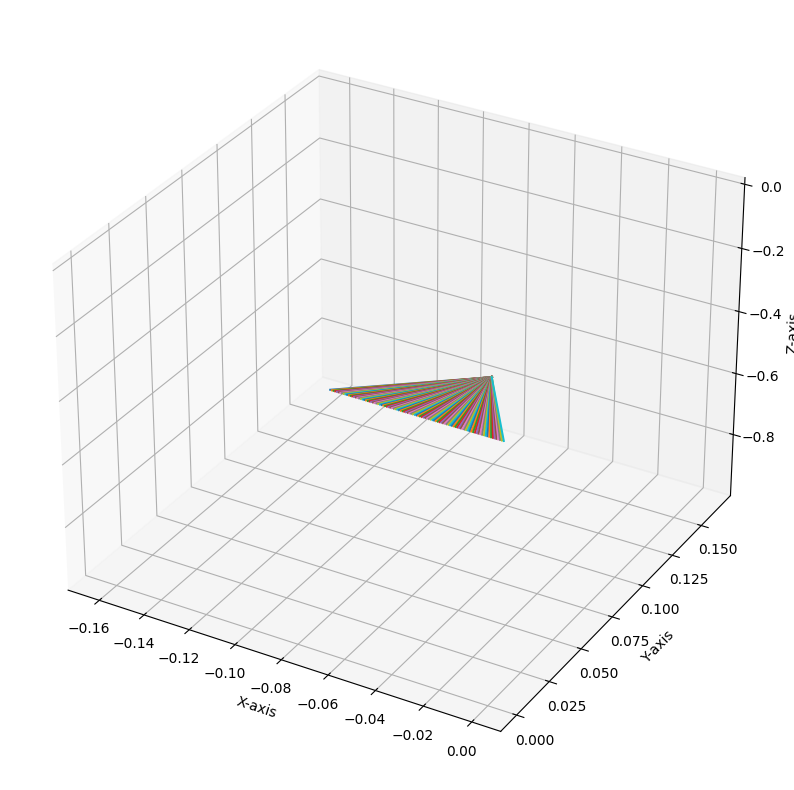

In [10]:
plot_rays(rays_origin, rays_direction, 1)

## Let's define a geometric shape

In [72]:
class Sphere:
    
    def __init__(self, p, r, c):
        self.center = p
        self.radius = r
        self.color = c
        
    def intersect(self, x):
        """
        Functions compute if the rays intersect with this shape and assigns color to rays
        x is a numpy array of points N,3
        """
        
        # (x - xc)**2 + (y - yc)**2 + (z - zc)**2 < r**2 point inside circle
        cond = ( x[:, 0] - self.center[0] ) ** 2 + ( x[:, 1] - self.center[1] )**2 + ( x[:, 2] - self.center[2] )**2 <= self.radius**2
        colors = torch.zeros((x.shape[0], 3))
        density = torch.zeros((x.shape[0], 1))
        colors[cond] = self.color.to(torch.float32)
        density[cond] = 10.
        # set_trace()
        return colors, density
        
        

In [73]:
device='cpu'
model = Sphere(torch.tensor([0., 0., -1.], device=device), 0.1, torch.tensor([1., 0., 0.], device=device)) # red color

def compute_accumulated_transmittance(betas):
    accumulated_transmittance = np.cumprod(betas, 1)
    accumulated_transmittance[:,0] = 1. # beause the loop starts from 1
    return accumulated_transmittance

def rendering(model, origin, dirs, tn, tf, num_bins=100, device='cpu'):
    """
    origin: npoints, 3
    rays: npoints, 3
    tn, tf: float
    """
    num_points = origin.shape[0]
    t = torch.linspace(tn, tf, num_bins).to(device)
    delta = torch.cat([t[1:] - t[:-1], torch.tensor([1e10], device=device)]) # numbins,
    r = origin.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * dirs.unsqueeze(1)  # npoints, nbins, 3
    colors, density = model.intersect(r.reshape(-1, 3))

    
    density = density.reshape(num_points, num_bins) # density: npoints * nbins
    colors = colors.reshape(num_points, num_bins, 3) # colors: npoints * nbins, 3
    
    alpha = 1 - torch.exp( - density * delta.unsqueeze(0)) # npoints, nbins
    T = compute_accumulated_transmittance(1 - alpha) # npoints, nbins
    final_colors = T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors
    final_colors = final_colors.sum(1)
    return final_colors
    # set_trace()

In [76]:
image_px = rendering(model, 
          torch.from_numpy(rays_origin).to(device),
          torch.from_numpy(rays_direction).to(device),
          0.8, 
          1.2,
          device='cpu'
         )

In [77]:
image_px = image_px.detach().cpu().numpy()
image_px.shape

(160000, 3)

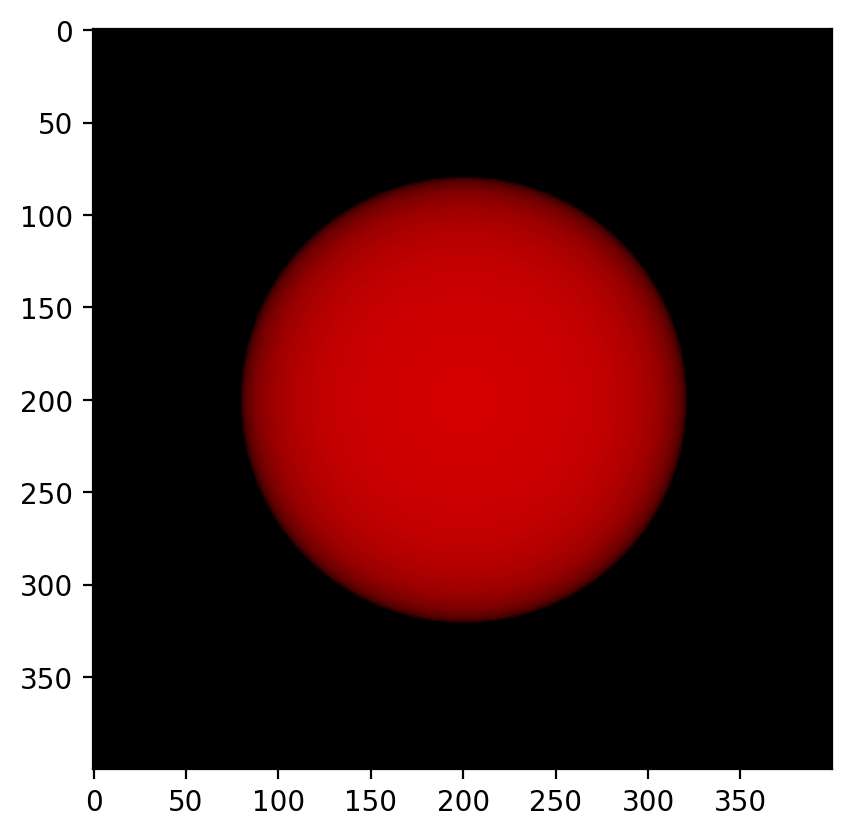

In [79]:
img = image_px.reshape(W, H, 3)
plt.figure(dpi=200)
plt.imshow(img)

## ---------------------------------------------------------------------------------------------------------

# Let's try to find the color given a model we have

In [81]:
## This is the ground truth model

gt_model = Sphere(torch.tensor([0., 0., -1.], device=device), 0.1, torch.tensor([1., 0., 0.], device=device)) # red color
gt_color_px = rendering(gt_model, 
                        torch.from_numpy(rays_origin).to(device=device),
                        torch.from_numpy(rays_direction).to(device=device),
                        0.8,
                        1.2,
                        device=device)


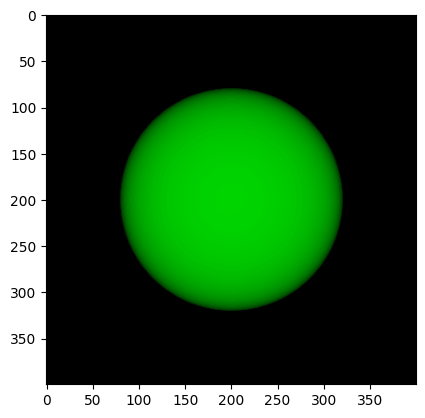

Epoch: 0     Loss: 0.09    Color: tensor([0.0273, 0.9727, 0.0000], requires_grad=True)


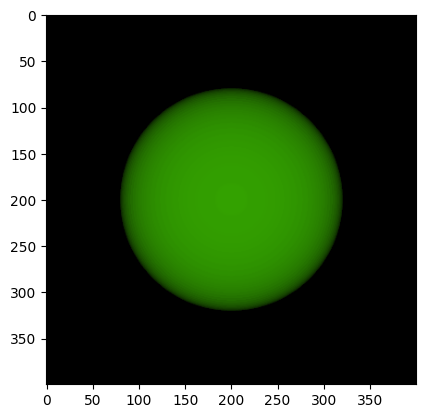

Epoch: 10     Loss: 0.05    Color: tensor([0.2627, 0.7373, 0.0000], requires_grad=True)


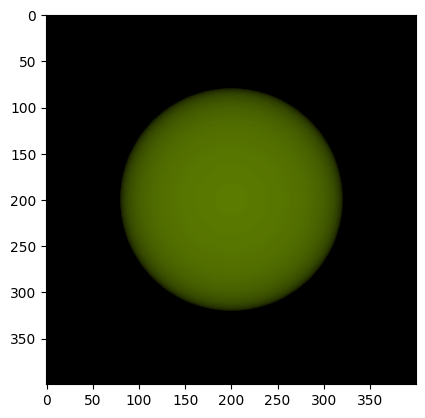

Epoch: 20     Loss: 0.03    Color: tensor([0.4411, 0.5589, 0.0000], requires_grad=True)


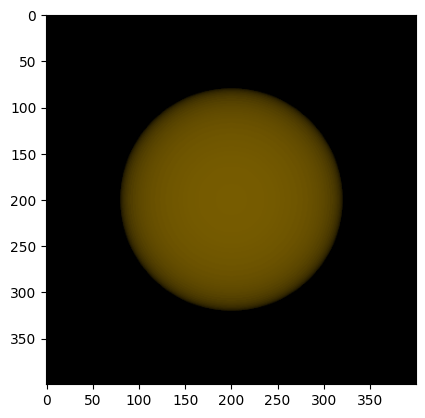

Epoch: 30     Loss: 0.02    Color: tensor([0.5763, 0.4237, 0.0000], requires_grad=True)


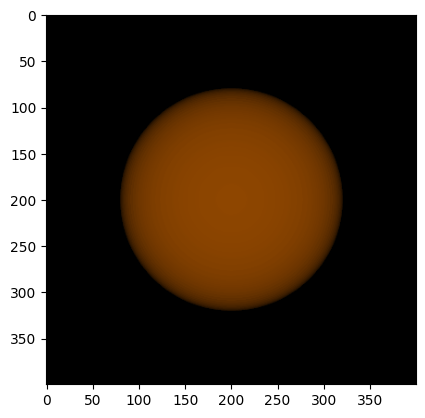

Epoch: 40     Loss: 0.01    Color: tensor([0.6788, 0.3212, 0.0000], requires_grad=True)


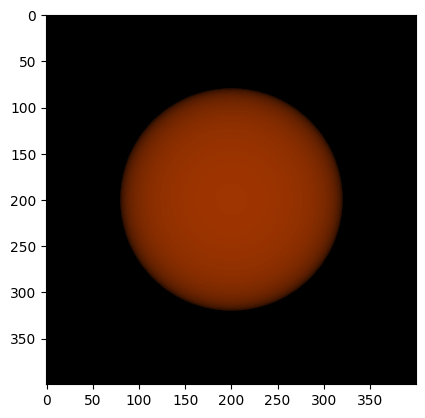

Epoch: 50     Loss: 0.01    Color: tensor([0.7565, 0.2435, 0.0000], requires_grad=True)


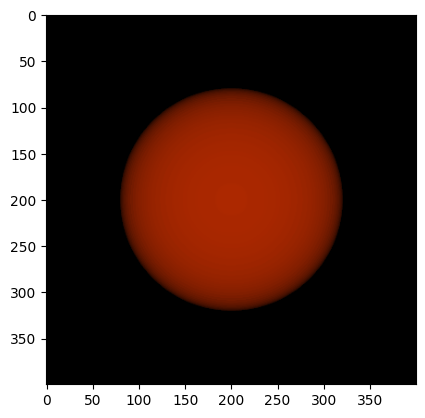

Epoch: 60     Loss: 0.0    Color: tensor([0.8154, 0.1846, 0.0000], requires_grad=True)


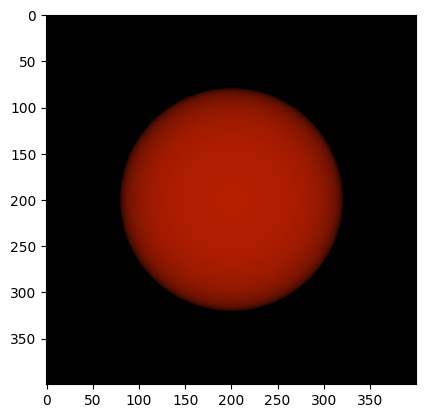

Epoch: 70     Loss: 0.0    Color: tensor([0.8601, 0.1399, 0.0000], requires_grad=True)


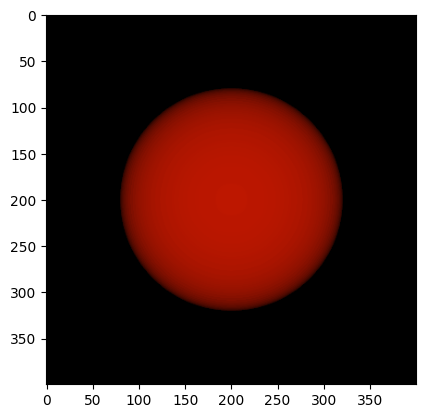

Epoch: 80     Loss: 0.0    Color: tensor([0.8939, 0.1061, 0.0000], requires_grad=True)


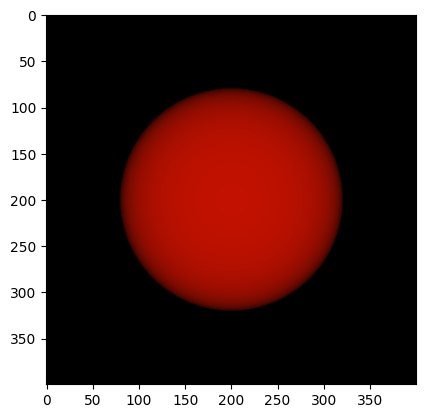

Epoch: 90     Loss: 0.0    Color: tensor([0.9196, 0.0804, 0.0000], requires_grad=True)


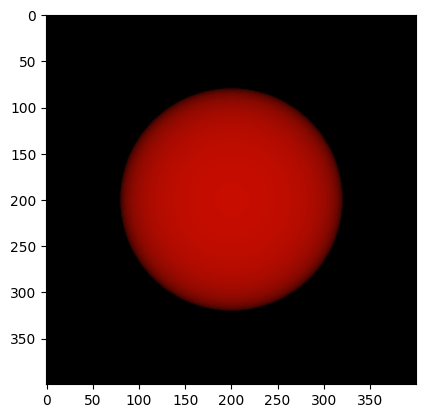

Epoch: 100     Loss: 0.0    Color: tensor([0.9391, 0.0609, 0.0000], requires_grad=True)


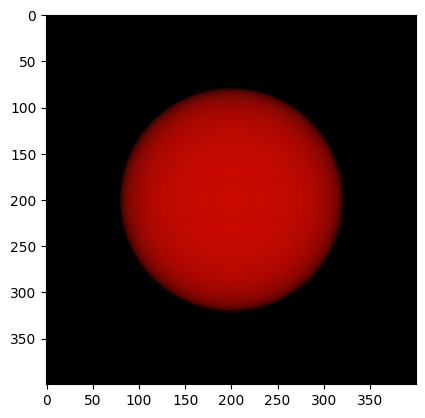

Epoch: 110     Loss: 0.0    Color: tensor([0.9538, 0.0462, 0.0000], requires_grad=True)


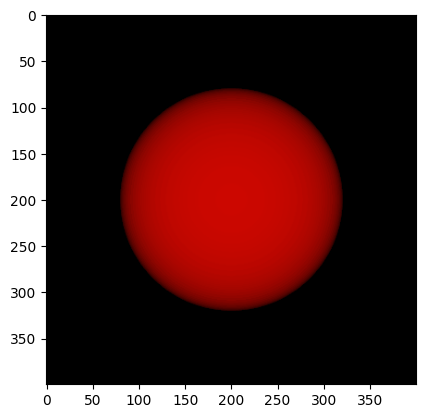

Epoch: 120     Loss: 0.0    Color: tensor([0.9650, 0.0350, 0.0000], requires_grad=True)


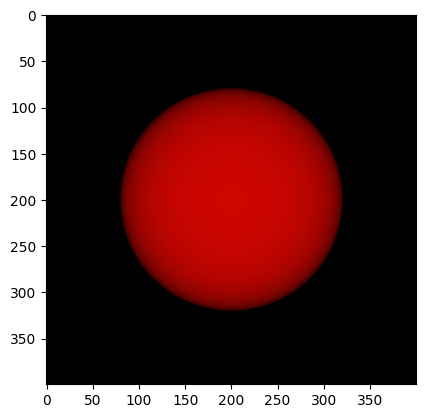

Epoch: 130     Loss: 0.0    Color: tensor([0.9735, 0.0265, 0.0000], requires_grad=True)


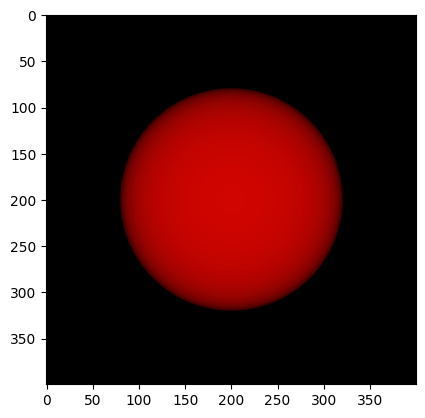

Epoch: 140     Loss: 0.0    Color: tensor([0.9799, 0.0201, 0.0000], requires_grad=True)


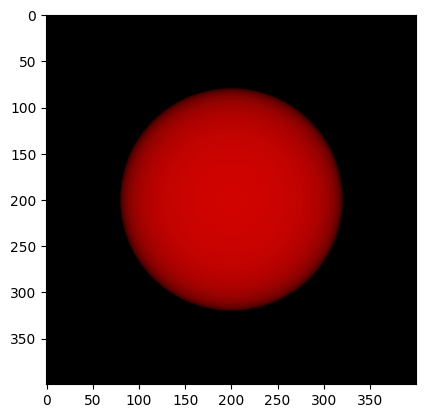

Epoch: 150     Loss: 0.0    Color: tensor([0.9847, 0.0153, 0.0000], requires_grad=True)


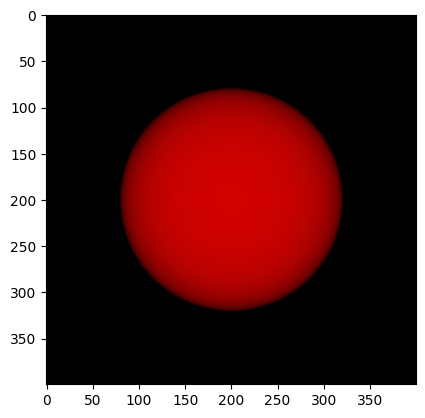

Epoch: 160     Loss: 0.0    Color: tensor([0.9884, 0.0116, 0.0000], requires_grad=True)


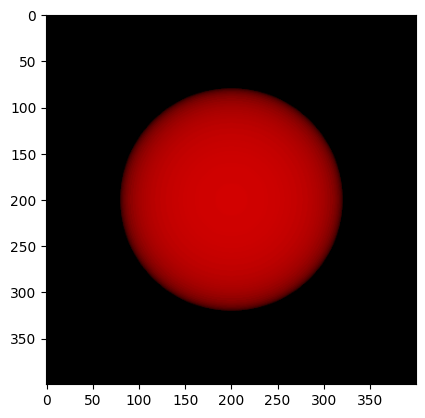

Epoch: 170     Loss: 0.0    Color: tensor([0.9912, 0.0088, 0.0000], requires_grad=True)


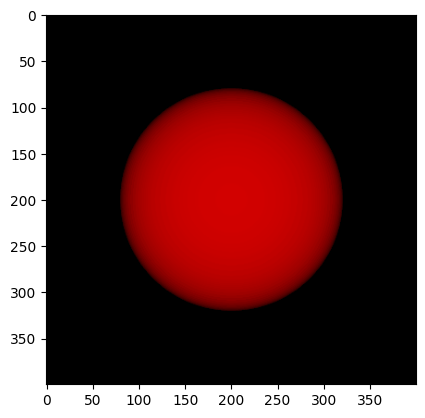

Epoch: 180     Loss: 0.0    Color: tensor([0.9934, 0.0066, 0.0000], requires_grad=True)


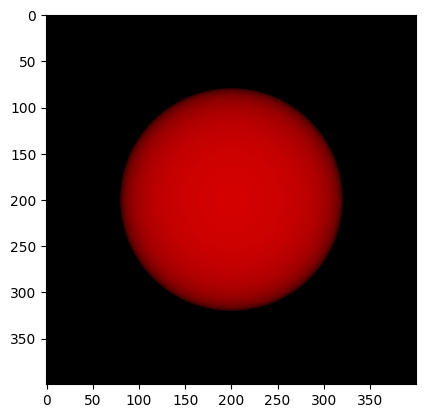

Epoch: 190     Loss: 0.0    Color: tensor([0.9950, 0.0050, 0.0000], requires_grad=True)


In [88]:
# We are trying to learn the color for our model

color_to_optimize = torch.tensor([0., 1., 0.], requires_grad=True, device=device) ## We start with a green color


optimizer = torch.optim.SGD({color_to_optimize}, lr=3e-1)

for epoch in range(200):
    model = Sphere(torch.tensor([0., 0., -1.], device=device),
               0.1, 
               color_to_optimize)
    Ax = rendering(model, 
                        torch.from_numpy(rays_origin).to(device=device),
                            torch.from_numpy(rays_direction).to(device=device),
                            0.8,
                            1.2,
                            device=device)

    loss = ((Ax - gt_color_px) **2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch %10 == 0:
        image = Ax.reshape(W, H, 3).detach().numpy()
        plt.imshow(image)
        plt.show()
        print(f"Epoch: {epoch}     Loss: {np.round(loss.item(), 2)}    Color: {color_to_optimize}")
        



## As you can see, the color changed to red